In [1]:
import numpy as np
from cvxopt import solvers
solvers.options['show_progress'] = False
from cvxopt import matrix
import matplotlib.pyplot as plt

In [2]:
def svm(X, y, C=1, print_matrix=False):
    """
    inputs
    X: data matrix, shape (N, d)
    y: label matrix, shape (N,)
    C: coefficient of slack terms in primal optimization, scalar 
    
    returns
    w: weight, shape (N,)
    b: bias, scalar
    """
    
    N = X.shape[0]
    Xy = X * y.reshape(N, 1)
    P = Xy.dot(Xy.T)
    q = -np.ones(N)

    G = np.concatenate((np.eye(N), -np.eye(N)))
    h = np.concatenate((C * np.ones(N), np.zeros(N)))

    A = y.reshape(1, N)
    b = np.zeros(1)

    if print_matrix:
        print('Inputs to solver')
        for array in ['P', 'q', 'G', 'h', 'A', 'b']:
            print(array + ':')
            print(eval(array))
    
    sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b))
    alphas = np.array(sol['x'])
    alphas[alphas < 1e-4] = 0
    
    w = (alphas.reshape(N, 1) * y.reshape(N, 1) * X).sum(axis=0)
    b = (y - X.dot(w))[(0 < alphas.reshape(N)) & (alphas.reshape(N) < C - 1e-4)].mean()
    return w, b

##### Below is a note about finding the bias $b$ in soft-margin SVMs in general. We don't use the method below for the code below because it's too much effort for an edge case, and instead we just assume that a support vector on the margin exists (although this may not be true). The note is just for your curiosity and understanding.

Once we find $\alpha$ we can obtain $w$ and calculate bias $b$ by looking for points on the margin boundary, $y_i (w^T x_i + b) = 1$. These points corresponds to the case where $0 < \alpha_i < C$. What if we have no such point where this holds? I.e. what if $\alpha_i = C$ or $\alpha_i = 0$ for all $i$?

If $y$ has multiple classes, not all $\alpha_i = 0$, since that would suggest that $w^* = 0$ and that the SVM will predict the same class for every point.

Then consider only the support vectors, where $\alpha_i = C$. In this case $y_i (w^T x_i + b) = 1 - \xi_i < 1$. We can't directly solve for $b$ in this case any more, unfortunately, so let's plug the optimal values of $w$ back into the primal objective and take a look.
$$\min_{w, b} \frac{1}{2} \lVert w\rVert^2 + C \sum_i \max \{0, 1 - y_i (w^T x_i + b) \}$$

After plugging in the optimal $w$, we can aim to find $b$ to minimize the objective.
$$\mathrm{argmin}_b \frac{1}{2} \lVert w\rVert^2 + C \sum_i \max \{0, 1 - y_i (w^T x_i + b) \} = \mathrm{argmin}_b \sum_i \max \{0, 1 - y_i (w^T x_i + b) \}$$

Since we already solved for the optimal $\alpha$, we know which $i$ are on the wrong side of the margin boundary since $\alpha_i = C$, and has $y_i (w^T x_i + b) < 1$ therefore $1 - y_i (w^T x_i + b) > 0$. The other points have $1 - y_i (w^T x_i + b) \leq 0$ so we can ignore them. Then the above $\mathrm{argmin}$ reduces to

$$\mathrm{argmin}_b \sum_{\{i|\alpha_i = C\}} \max \{0, 1 - y_i (w^T x_i + b) \} = \mathrm{argmin}_b \sum_{\{i|\alpha_i = C\}} 1 - y_i (w^T x_i + b) = \mathrm{argmin}_b b \sum_{\{i|\alpha_i = C\}} -y_i$$

subject to constraints $1 - y_i (w^T x_i + b) > 0$ for $\{i | \alpha_i = C \}$.

You can see that if there's an equal number of positively-labeled and negatively-labeled support vectors, then $\sum_{\{i|\alpha_i = C\}} -y_i = 0$, and any $b$ that satisfies the contraints is optimal. You can imagine that these positively-labeled and negatively-labeled points are within the margin, and as long as you slide the margin up and down without any of the points crossing the margin boundary, the optimal value of the primal objective stays the same. Actually in this case the problem has multiple optimal solutions (the convex optimization solver just finds one), and you can imagine another $\alpha'$ that's not returned by the solver, but results in the same optimal value as $\alpha$, but puts one of the support vectors on the margin boundary, and there exists an $i$ such that $\alpha_i = C$ and $1 - y_i (w^T x_i + b) < 0$ while $0 < \alpha_i' < C$ and $1 - y_i (w'^T x_i + b') = 0$.

On the other hand, we will show that in this case it's not possible to have $\sum_{\{i|\alpha_i = C\}} -y_i \neq 0$, which suggests that there is an unequal number of positively-labeled and negatively-labeled support vectors inside the margin boundary (with no support vectors on the margin boundary). Assume for contradiction that the previous scenario is possible, then when we solve the optimization problem above, $b$ will shift the margins to minimize the total slack, while still obeying the constraints. But since $b$ cannot shift the margin so that a support vector lies on the margin boundary (since earlier we said there were no $0 < \alpha_i < C$), the optimal value is worse than the optimal value for an $\alpha'$ which does have a support vector on the margin boundary. But then $\alpha$ would not be optimal, and we have a contradiction.

In [3]:
# X is data matrix (each row is a data point)
# Y is desired output (1 or -1)
# scoreFn is a function of a data point
# values is a list of values to plot

def plot_decision_boundary(X, Y, score_fn, contour_values=[-1, 0, 1], title=''):
    """
    inputs
    X: data matrix, shape (N, d)
    y: label matrix, shape (N)
    score_fn: predicts a scalar score for an input of shape (d,)
    contour_values: values of contour lines to display
    """
    
    # Plot the decision boundary. For that, we asign a score to
    # each point in the mesh [x_min, m_max] x [y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    h = max(x_max - x_min, y_max - y_min) / 200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    zz = np.array([score_fn(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    zz = zz.reshape(xx.shape)
    CS = plt.contour(xx, yy, zz, contour_values, colors='green', linestyles='solid', linewidths=2)
    plt.clabel(CS, fontsize=9, inline=1)
    plt.scatter(X[:, 0], X[:, 1], c=(1 - Y).ravel(), s=50, cmap = plt.cm.cool)
    plt.title(title)
    plt.axis('tight')
    plt.show()

In [4]:
def run_svm(X,y):
    # Training
    w, b = svm(X, y)
    score_fn = lambda x: w.dot(x) + b
    plot_decision_boundary(X, y, score_fn, title='SVM Train')
    
    preds = np.array([score_fn(x) for x in X])
    print('Training error', (preds * y <= 0).mean())

## 3.3

In [5]:
def kernel_svm(X, y, k=None, C=1):
    """
    inputs
    X: data matrix, shape (N, d)
    y: label matrix, shape (N,)
    k: if k is None, then compute the kernel by XX^T; else k could be a function or precomputed matrix
    C: coefficient of slack terms in primal optimization, scalar 
    
    returns
    w: weight, shape (N,)
    b: bias, scalar
    """
    
    N = len(y)
    if callable(k):
        K = k(X, X)
    elif k is None:
        K = X.dot(X.T)
    else:
        K = k

    P = K.reshape(N, N) * y.reshape(N, 1).dot(y.reshape(1, N))
    q = -np.ones(N)

    G = np.concatenate((np.eye(N), -np.eye(N)))
    h = np.concatenate((C * np.ones(N), np.zeros(N)))

    A = y.reshape(1, N)
    b = np.zeros(1)
    
    sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b))
    alpha = np.array(sol['x'])
    alpha[alpha < 1e-4] = 0
    
    return alpha.reshape(-1)

ker_linear = lambda X1, X2: X1.dot(X2.T)
def ker_rbf(X1, X2, gamma):
    if len(X1.shape) == 1:
        X1 = X1.reshape(1, -1) # (N1, d)
    if len(X2.shape) == 1:
        X2 = X2.reshape(1, -1) # (N2, d)
    X1 = np.expand_dims(X1, axis=1) # (N1, 1, d)
    X2 = np.expand_dims(X2, axis=0) # (1, N2, d)
    
    # broadcasting trick
    return np.exp(-gamma * np.sum((X1 - X2) ** 2, axis=2))

### Small Example for test

In [ ]:
pos = np.load('../data/svm/in.npy')
neg = np.load('../data/svm/out.npy')
X = np.concatenate((pos, neg))
y = np.concatenate((np.ones(len(pos)), -np.ones(len(neg))))

ker = ker_linear
ker = lambda X1, X2: ker_rbf(X1, X2, gamma=1)
C = 1

alpha = kernel_svm(X, y, k=ker, C=C)

is_support_vector = (0 < alpha) & (alpha < C)
y_sv = y[is_support_vector]
X_sv = X[is_support_vector]

b = (y_sv - ((alpha * y).reshape(-1, 1) * ker(X, X_sv)).sum(axis=0)).mean()

pred_svm = lambda x: (alpha * y * ker(X, x).reshape(-1)).sum(axis=0) + b

plot_decision_boundary(X, y, pred_svm, title='Small Example')

### Full data examples

In [15]:
def run(name='1', ker=ker_linear, C=1):
    train = np.loadtxt('data/data' + name + '_train.csv')

    X = train[:, 0:2].copy()
    y = train[:, 2].copy()

    alpha = kernel_svm(X, y, k=ker, C=C)

    is_support_vector = (0 < alpha) & (alpha < C)
    y_sv = y[is_support_vector]
    X_sv = X[is_support_vector]

    b = (y_sv - ((alpha * y).reshape(-1, 1) * ker(X, X_sv)).sum(axis=0)).mean()

    pred_svm = lambda x: (alpha * y * ker(X, x).reshape(-1)).sum(axis=0) + b

    plot_decision_boundary(X, y, pred_svm, title='SVM Train')

    validate = np.loadtxt('data/data' + name + '_validate.csv')
    X_val = validate[:, 0:2]
    y_val = validate[:, 2:3]

    plot_decision_boundary(X_val, y_val, pred_svm, title='SVM Validation')

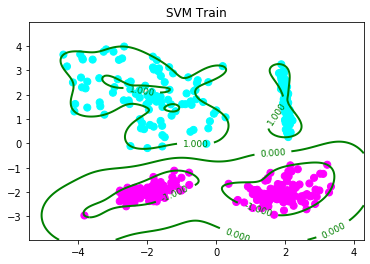

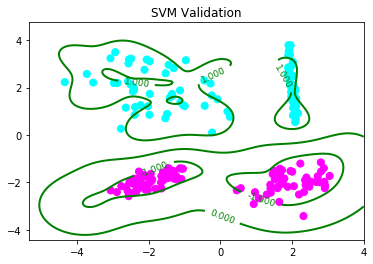

In [19]:
run(name='1', ker=lambda X1, X2: ker_rbf(X1, X2, gamma=1), C=100)

# 4 Soft-Margin SVM with Pegasos

## 4.1

In [20]:
from tqdm import tqdm

def pegasos(X, y, epochs=1000, lam=1):
    t = 0
    w = np.zeros(X.shape[1])
    b = 0
    for _ in tqdm(range(epochs)):
        for xi, yi in zip(X, y):
            t += 1
            eta = 1 / (t * lam)
            if yi * (w.dot(xi) + b) < 1:
                w = (1 - eta * lam) * w + eta * yi * xi
                b = b + eta * yi
            else:
                w = (1 - eta * lam) * w
    return w, b

ModuleNotFoundError: No module named 'tqdm'

In [21]:
X = np.concatenate((pos, neg))
y = np.concatenate((np.ones(len(pos)), -np.ones(len(neg))))

w, b = pegasos(X, y, epochs=10000)

pred_svm = lambda x: w.dot(x) + b

plt.figure(figsize=(5, 5))
plot_decision_boundary(X, y, pred_svm, title='Small Example')

NameError: name 'pegasos' is not defined

## 4.2

In [52]:
def run(name='1', epochs=1000, lam=2e-2):
    train = np.loadtxt('data/data' + name + '_train.csv')
    X = train[:,0:2]
    y = train[:,2]

    w, b = pegasos(X, y, epochs=epochs, lam=lam)
    
    pred_svm = lambda x: w.dot(x) + b
    
    plot_decision_boundary(X, y, pred_svm, title='Linear SVM')

100%|██████████| 1000/1000 [00:01<00:00, 692.32it/s]


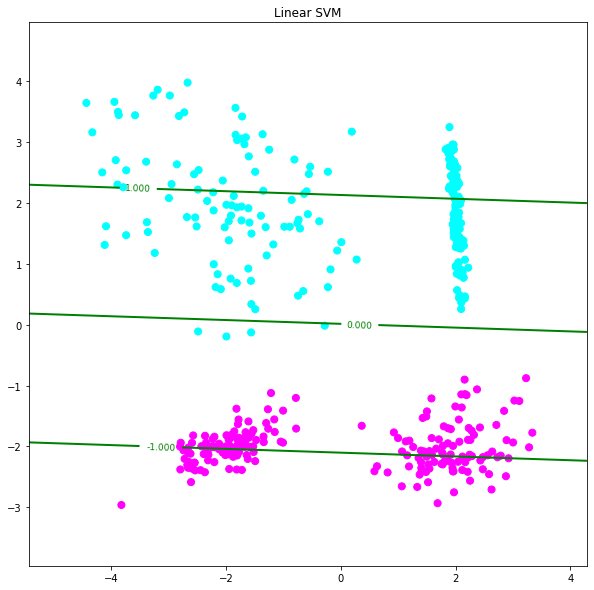

In [53]:
plt.figure(figsize=(10, 10))
run('1', epochs=1000, lam=2)

100%|██████████| 20000/20000 [00:17<00:00, 1122.91it/s]


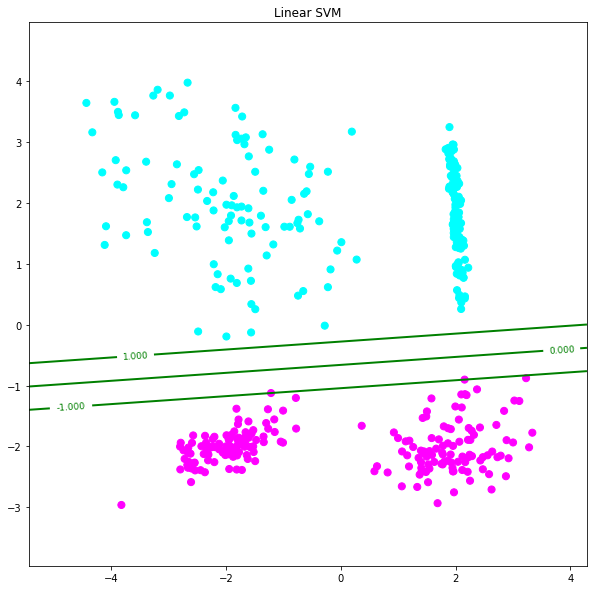

In [54]:
plt.figure(figsize=(10, 10))
run('1', epochs=20000, lam=2e-3)

100%|██████████| 20000/20000 [00:17<00:00, 1112.08it/s]


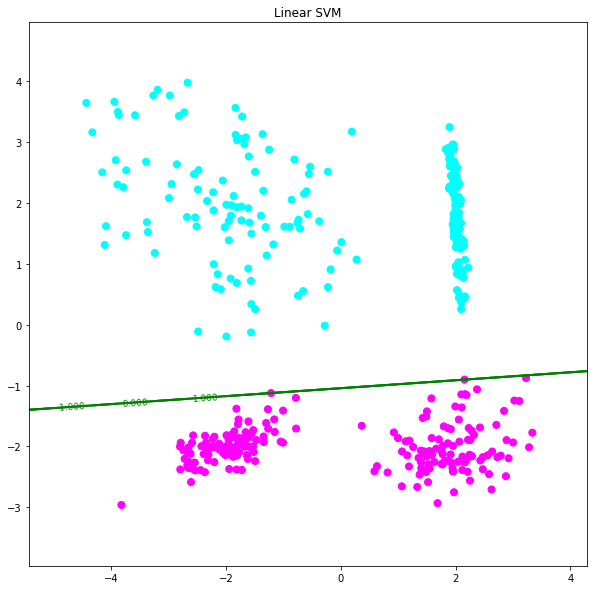

In [55]:
plt.figure(figsize=(10, 10))
run('1', epochs=20000, lam=2e-10)

Margin decreases as lambda decreases.

## 4.3

In [56]:
def kernel_pegasos(K, y, epochs=1000, lam=1):
    t = 0
    a = np.zeros(K.shape[1])
    for _ in tqdm(range(epochs)):
        for i, (ki, yi) in enumerate(zip(K, y)):
            t += 1
            eta = 1 / (t * lam)
            if yi * (a * y * ki).sum() < 1:
                a[i] = (1 - eta * lam) * a[i] + eta
            else:
                a[i] = (1 - eta * lam) * a[i]
    return a

You should make a new prediction for a new point x by calculating the kernel value between x and the support vector points. There is the same sparsity in the support vectors as in alpha.

## 4.4

In [63]:
def run(name='1', epochs=1000, lam=0.02, gamma=2):
    train = np.loadtxt('data/data' + name + '_train.csv')
    
    X = train[:, 0:2]
    y = train[:, 2]

    ker = lambda X1, X2: ker_rbf(X1, X2, gamma=gamma)
    K = ker(X, X)
    
    alpha = kernel_pegasos(K, y, lam=lam, epochs=epochs)
    X_sv = X[alpha > 0]
    
    is_support_vector = 0 < alpha
    y_sv = y[is_support_vector]
    X_sv = X[is_support_vector]

    b = (y_sv - ((alpha * y).reshape(-1, 1) * ker(X, X_sv)).sum(axis=0)).mean()

    pred_svm = lambda x: (alpha * y * ker(X, x).reshape(-1)).sum(axis=0) + b

    plot_decision_boundary(X, y, pred_svm, title='Gaussian Kernel SVM')

100%|██████████| 1000/1000 [00:02<00:00, 361.38it/s]


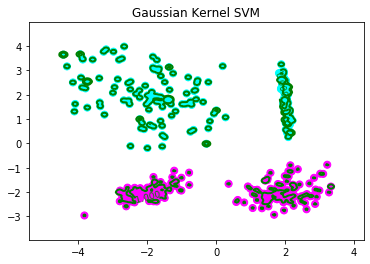

In [66]:
run('1', gamma=2e2)

100%|██████████| 1000/1000 [00:02<00:00, 384.90it/s]


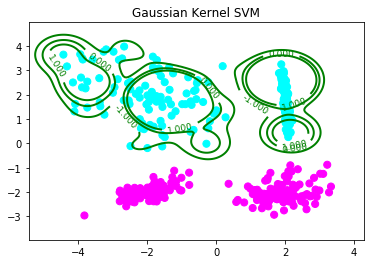

In [64]:
run('1')

100%|██████████| 2000/2000 [00:05<00:00, 376.58it/s]


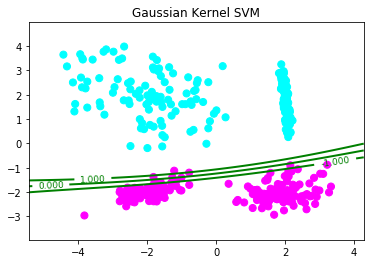

In [67]:
run('1', epochs=2000, gamma=2e-2)

$\gamma$ controls the bias-complexity trade-off. Small $\gamma$ leads to high bias and low variance (underfitting) and large $\gamma$ leads to low bias and high variance (overfitting), because larger $\gamma$ forces the boundary to consider fewer nearby points. The Gaussian RBF kernel can make boundaries that fit the data better, but is prone to overfitting.